<a href="https://colab.research.google.com/github/dnguyend/par-trans/blob/main/examples/NumpySO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workbook to test SO parallel transport with a deformed metric using numpy.

This should be run under CPU run time.


In [1]:
!pip install git+https://github.com/dnguyend/par-trans

  Cloning https://github.com/dnguyend/par-trans to /tmp/pip-req-build-tej5jj8f
  Running command git clone --filter=blob:none --quiet https://github.com/dnguyend/par-trans /tmp/pip-req-build-tej5jj8f
  Resolved https://github.com/dnguyend/par-trans to commit 8a7b9ef3c88d929d40c9a9f990cf257132243f46
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for par-trans: filename=par_trans-0.1.dev17+g8a7b9ef-py3-none-any.whl size=32089 sha256=bf9f9de2604baf2372bf119750bd40ce4aead2d16caefa859ac57f28924ee41d
  Stored in directory: /tmp/pip-ephem-wheel-cache-t48goqnb/wheels/43/54/27/33e127e64ed29c538e4b5356c5a5801c527ecfa659afe8ec3c
Successfully built par-trans


Import the libraries

In [4]:
import numpy as np
import numpy.linalg as la
from numpy.random import randn

from par_trans.manifolds import SOAlpha
from par_trans.utils.utils import (sym, asym, lie, cz)

from scipy.linalg import expm
from scipy.sparse.linalg import expm_multiply, LinearOperator


Run several tests:
* check the metric compatible condition of the Levi-Civita connection. For 2 tangent vectors $v, va$, $X: z\mapsto soa.proj(z, va)$ is a vector field. We compare $D_v\langle X, X\rangle$ and $2\langle X, D_vX + \Gamma(v, X)\rangle$
* Check Geodesic and transport equations.
* The function soa.exp gives the Riemannian exponential map, while $soa.dexp(x, v, t,ddexp=True) $ computes $\gamma(t), \dot{\gamma}(t)$ and $\ddot{\gamma}(t)$ where $\gamma(t)$ is the geodesic starting at $x$ with initial velocity $\dot{\gamma}(0) = v$. If $ddexp=False$, only $\gamma$ and $\dot{\gamma}$ are returned.

We verify dexp indeed returns the time derivatives, and show the parallel transport equation is satisfied.


In [5]:

def test():
    n = 5
    k = 3
    alp = .6
    soa = SOAlpha(n, k, alp)

    x = soa.rand_point()
    v = soa.rand_vec(x)
    va = soa.rand_vec(x)
    c = soa.rand_vec(np.eye(n))

    dlt = 1e-6
    t = .8

    print("Check Christoffel gamma produces a metric compatible connection")
    print((soa.inner(x+dlt*v, soa.proj(x+dlt*v, va), soa.proj(x+dlt*v, va)) - soa.inner(x, va, va))/dlt)
    print(2*soa.inner(x, va, soa.christoffel_gamma(x, v, va)))

    print("Check time derivatives of geodesics")
    print(np.allclose((soa.exp(x, (t+dlt)*v) - soa.exp(x, t*v))/dlt,
                      soa.dexp(x, v, t, ddexp=False)[1], atol=1e-3
                      ))

    print(np.allclose((soa.dexp(x, v, t+dlt)[1] - soa.dexp(x, v, t)[1])/dlt,
                      soa.dexp(x, v, t, ddexp=True)[2], atol=1e-2
                      ))

    gmms = soa.dexp(x, v, t, ddexp=True)

    print("CHECK Geodesic Equation with analytic differentiation")
    print(gmms[2] + soa.christoffel_gamma(gmms[0], gmms[1], gmms[1]))

    Delta = soa.parallel(x, v, va, t)

    print("CHECK TRANSPORT EQUATION with numerical differentiation")
    print((soa.parallel(x, v, va, t+dlt) - Delta)/dlt \
          + soa.christoffel_gamma(gmms[0], gmms[1], Delta))
test()

Check Christoffel gamma produces a metric compatible connection
-0.18386036781947723
-0.18389611899372452
Check time derivatives of geodesics
True
True
CHECK Geodesic Equation with analytic differentiation
[[ 2.22044605e-15  1.33226763e-15 -3.05311332e-16  3.10862447e-15
  -1.99840144e-15]
 [-2.66453526e-15 -2.22044605e-15 -5.55111512e-16 -3.55271368e-15
   2.22044605e-15]
 [-4.44089210e-16 -4.44089210e-16  3.33066907e-16 -1.99840144e-15
   1.27675648e-15]
 [ 2.22044605e-15  0.00000000e+00 -1.22124533e-15  8.88178420e-16
  -1.33226763e-15]
 [ 2.66453526e-15  2.10942375e-15 -1.11022302e-16  4.88498131e-15
  -3.10862447e-15]]
CHECK TRANSPORT EQUATION with numerical differentiation
[[ 2.27632289e-06 -2.59121290e-06 -5.40727136e-08  2.15351174e-06
  -2.27413650e-06]
 [ 8.60518035e-08  2.79094431e-06 -4.95865637e-07  2.13440958e-06
  -3.48185664e-07]
 [-7.90778310e-07  1.21409607e-06  2.42879606e-07 -6.42812042e-08
   4.99570600e-07]
 [ 1.30777859e-06  7.16161548e-07 -7.52266696e-07  3.5294

In [9]:
def check_time_d():
  t = 30.
  n_list = [4, 10, 50, 100]
  # n_list = [2, 3]
  for n in n_list:
    alp = .6
    k = 3
    soa = SOAlpha(n, k, alp)

    x = soa.rand_point()
    v = soa.rand_vec(x)
    v = v/np.sqrt(soa.inner(x, v, v))
    va = soa.rand_vec(x)
    t0 = perf_counter()
    soa.parallel(x, v, va, t)
    t1 = perf_counter()
    print("n=%d time=%f(s)" % (n, t1-t0))
check_time_d()

n=4 time=0.023996(s)
n=10 time=0.016216(s)
n=50 time=0.037980(s)
n=100 time=0.185816(s)


# TEST ISOMETRY

We show the inner product metric is preserved to around $10^{-12}$ accuracy up to $t=15$. THis will take a while to run.

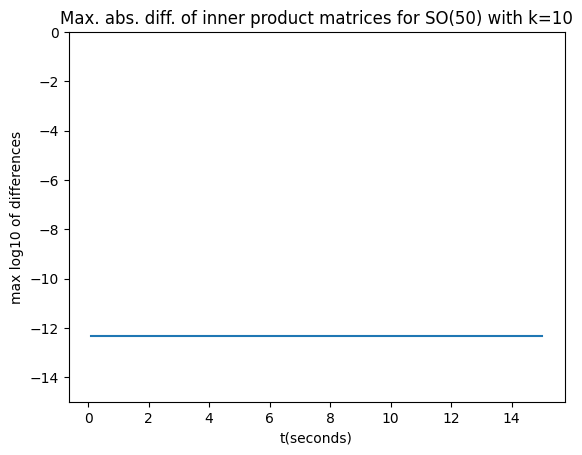

array([[  0.1       , -12.34222982],
       [  0.3       , -12.34222982],
       [  0.5       , -12.34222982],
       [  0.7       , -12.34222982],
       [  1.2       , -12.34222982],
       [  1.5       , -12.34222982],
       [  1.7       , -12.34222982],
       [  2.1       , -12.34222982],
       [  3.        , -12.34222982],
       [ 15.        , -12.34222982]])

In [13]:
import matplotlib.pyplot as plt
import numpy.linalg as la

np.random.seed(0)

alp = .6

n = 50
k = 10
soa = SOAlpha(n, k, alp)

x = np.eye(soa.shape[1])

n_samples = 20

all_smpl = []

def normalize(a, x):
    return a / np.sqrt(soa.inner(x, a, a))

for _ in range(n_samples):
    spl = soa.rand_vec(x)
    ft = np.random.choice(3*n_samples, (), replace=True)

    all_smpl.append(ft*normalize(spl, x))

all_smpl = np.array(all_smpl)


def cal_cov(gm, smpls):
    mat = np.zeros((n_samples,  n_samples))
    for i in range(n_samples):
        for j in range(i+1):
            mat[i, j] = soa.inner(gm, smpls[i, :, :], smpls[j, :, :])
            if i != j:
                mat[j, i] = mat[i, j]
    return mat

cov_0 = cal_cov(x, all_smpl)

v = soa.rand_vec(x)
v = v/np.sqrt(soa.inner(x, v, v))

cov_diff = []
# t_grid = [0.5, 1., 2., 5., 10., 15.]
# t_grid = [0.5, 1.]
t_grid = [0.1, .3, .5, .7, 1.2, 1.5, 1.7, 2.1, 3., 15.]
for t in t_grid:
    transported = []
    for i in range(n_samples):
        transported.append(soa.parallel(x, v, all_smpl[i, :, :], t))

    transported = np.array(transported)
    gm = soa.exp(x, t*v)
    cov_t = cal_cov(gm, transported)
    # print(cz(cov_t- cov_0))
    cov_diff.append((t, cov_t))

plt.plot(t_grid, [np.log10(cz(cov_diff[i][1] - cov_0)) for i in range(len(cov_diff))])
plt.ylim(-15, 0)
plt.xlabel("t(seconds)")
plt.ylabel("max log10 of differences")
plt.title("Max. abs. diff. of inner product matrices for SO(%d) with k=%d" % (n, k))
plt.savefig("cov_diff_flag.png")
plt.show()
display(np.concatenate([np.array(t_grid)[:, None], np.array([np.log10(cz(cov_diff[i][1] - cov_0)) for i in range(len(cov_diff))])[:, None]], axis=1))

In [14]:
from psutil import *
# This code will return the number of CPU
print("Number of CPU: ", cpu_count())
# This code will return the CPU info
!cat /proc/cpuinfo

Number of CPU:  2
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.170
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4400.34
clflush size	: 64
cache

In [15]:
virtual_memory()

svmem(total=13609431040, available=12565209088, percent=7.7, used=710356992, free=10024099840, active=802373632, inactive=2491342848, buffers=395239424, cached=2479734784, shared=1650688, slab=214016000)